# AuralSent: Harmonizing Text and Sound for Sentiment Analysis

In [1]:
#!pip install SpeechRecognition
#!pip install librosa

### Data:

https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/datae

In [1]:
import warnings
warnings.filterwarnings ('ignore')

# Import necessary libraries
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

# Set style for plotting
plt.style.use('seaborn')
sns.set_style('darkgrid')



2024-03-22 17:58:58.349823: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


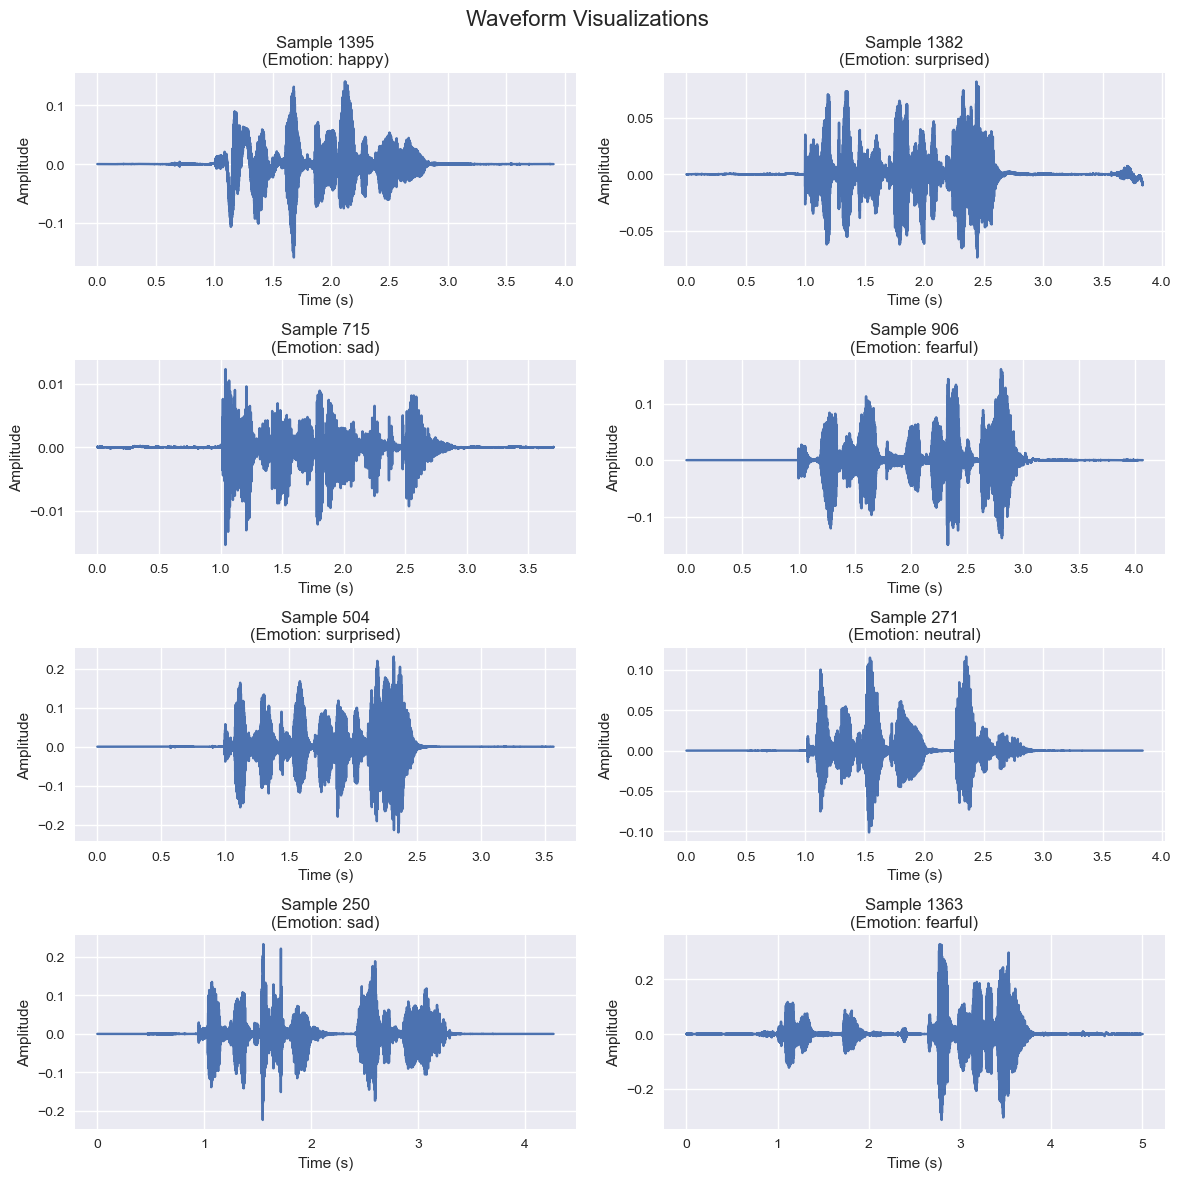

In [2]:
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

speech_data = []  # This will contain file paths
speech_labels = []  # This will contain corresponding labels
dataset_path = 'archive/'

actor_dirs = [adir for adir in os.listdir(dataset_path) if adir.startswith("Actor_")]
for actor_dir in actor_dirs:
    actor_path = os.path.join(dataset_path, actor_dir)
    filenames = os.listdir(actor_path)
    for filename in filenames:
        speech_data.append(os.path.join(actor_path, filename))
        # Assuming label is the third item in filename split by '-'
        speech_labels.append(int(filename.split('-')[2]) - 1)  # Adjust based on your dataset structure

#Random Sample Selection: Choose random samples from your dataset for visualization. 
sample_indices = np.random.choice(len(speech_data), size=8, replace=False)



num_rows = 4
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

fig.suptitle("Waveform Visualizations", fontsize=16)

for i, index in enumerate(sample_indices):
    row = i // num_cols
    col = i % num_cols

    audio_data, sr = librosa.load(speech_data[index])
    label_index = speech_labels[index]
    emotion = emotion_labels[label_index]

    duration = len(audio_data) / sr
    time = np.linspace(0, duration, num=len(audio_data))

    ax = axes[row, col]
    ax.plot(time, audio_data)
    ax.set_title(f"Sample {index+1}\n(Emotion: {emotion})")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


### Fetaures

*   **Mel-Frequency Cepstral Coefficients (MFCCs)**: These coefficients are a representation of the short-term power spectrum of sound and are widely used in voice recognition and music information retrieval. They effectively capture the timbral aspects that are important for distinguishing between different emotional expressions.
    
*   **Chroma Features**: These features are based on the twelve different pitch classes and are useful for analyzing music and speech by summarizing information about harmonics and chords, which can vary significantly with emotional content.
    
*   **Mel-Spectrogram**: This represents the spectrum of frequencies of a sound signal as they vary with time. It's more sensitive to changes in emotional intensity than traditional spectrograms due to its emphasis on perceptually relevant frequencies.
    
*   **Spectral Contrast**: This feature captures the contrast in spectral peaks and valleys within the sound spectrum, reflecting the dynamic range of the audio signal which can be indicative of emotional intensity.
    
*   **Tonnetz**: Derived from the tonal centroid features, it captures harmonic relationships within audio signals and can provide insights into the emotional coloring of speech.
    
*   **Pitch**: The average pitch of the audio signal, which can vary with emotional states, such as higher pitches often associated with excited or anxious emotions.
    
*   **Magnitude**: Extracted alongside pitch through pitch tracking, representing the intensity of audio signals which can be an indicator of emotional strength.
    
*   **Tempo**: The overall tempo of the audio signal can also relate to the emotional content, with faster tempos potentially indicating higher levels of energy or agitation.

*   **Zero-Crossing Rate**: The rate at which the signal changes from positive to negative or back. This feature can be useful for distinguishing between different types of emotional expressions, as it relates to the textural characteristics of the sound.
    
*   **Energy**: The sum of squares of the signal, frame by frame, can indicate the loudness or intensity level of the speech, which is often correlated with emotional intensity.
    
*   **Entropy of Energy**: Measures the unpredictability of the energy in the audio signal, which could vary with different emotional states due to changes in the signal's dynamics.
    
*   **Formants**: The peak resonances in the vocal tract signal can provide information about the speaker's emotional state, as emotions can cause physiological changes that affect these resonances.



### advanced featuures

In [ ]:
import librosa
import numpy as np
from tqdm import tqdm
import os
from tensorflow.keras.utils import to_categorical

def spectral_entropy(y, sr, n_fft=2048, hop_length=512):
    """
    Calculate the spectral entropy of an audio signal with Librosa.
    """
    D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))**2
    S = librosa.power_to_db(D, ref=np.max)
    S_normalized = np.exp(S - np.max(S))
    S_normalized /= S_normalized.sum(axis=0)
    spectral_entropy = -np.sum(S_normalized * np.log2(S_normalized + 1e-8), axis=0)
    return np.mean(spectral_entropy)

def extract_comprehensive_features(file_path):
    """
    Extract an extended set of features including MFCCs, Chroma, Mel-Spectrogram,
    Spectral Contrast, Tonnetz, pitch, magnitude, tempo, Zero-Crossing Rate,
    Energy, and Spectral Entropy from an audio file.
    """
    y, sr = librosa.load(file_path, sr=None)

    # Basic audio features
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=np.abs(librosa.stft(y)), sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=np.abs(librosa.stft(y)), sr=sr).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)

    # Additional features: pitch, magnitude, and tempo
    pitch, mag = librosa.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitch)
    mag_mean = np.mean(mag)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    # Zero-Crossing Rate
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y)[0])

    # Energy
    energy = np.sum(np.square(y)) / len(y)

    # Spectral Entropy
    entropy = spectral_entropy(y, sr)

    # Combine all features into a single array
    features = np.hstack([
        mfccs, chroma, mel, contrast, tonnetz, pitch_mean, mag_mean, tempo,
        zero_crossing_rate, energy, entropy
    ])
    
    return features

def extract_all_features_and_labels_with_additional(dataset_path):
    features = []
    labels = []

    actor_dirs = [adir for adir in os.listdir(dataset_path) if adir.startswith("Actor_")]
    for actor_dir in tqdm(actor_dirs, desc="Processing Actors"):
        actor_path = os.path.join(dataset_path, actor_dir)
        filenames = os.listdir(actor_path)
        for filename in filenames:
            file_path = os.path.join(actor_path, filename)
            audio_features = extract_comprehensive_features(file_path)
            features.append(audio_features)
            labels.append(int(filename.split('-')[2]) - 1)  # Adjust based on your dataset structure

    labels = np.array(labels)
    labels = to_categorical(labels)

    return np.array(features), labels

# Example usage
dataset_path = 'archive/'
features, labels = extract_all_features_and_labels_with_additional(dataset_path)


Processing Actors:  17%|████▏                    | 4/24 [02:16<11:21, 34.09s/it]

## load data

In [9]:
def extract_features_and_labels(dataset_path):
    features, labels = [], []
    actor_dirs = [adir for adir in os.listdir(dataset_path) if adir.startswith("Actor_")]
    for actor_dir in tqdm(actor_dirs, desc="Actors Progress"):
        actor_path = os.path.join(dataset_path, actor_dir)
        filenames = os.listdir(actor_path)
        for filename in filenames:
            file_path = os.path.join(actor_path, filename)
            # Extract MFCCs
            y, sr = librosa.load(file_path, sr=None)  # 'sr=None' for the file's original sample rate
            mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
            features.append(mfccs)
            # Extract emotion (3rd item in the filename split by '-')
            labels.append(int(filename.split('-')[2]) - 1)  # Subtract 1 to make labels start from 0
    return np.array(features), to_categorical(np.array(labels))


dataset_path = 'archive/'
features, labels = extract_features_and_labels(dataset_path)


Actors Progress: 100%|██████████████████████████| 24/24 [00:14<00:00,  1.63it/s]


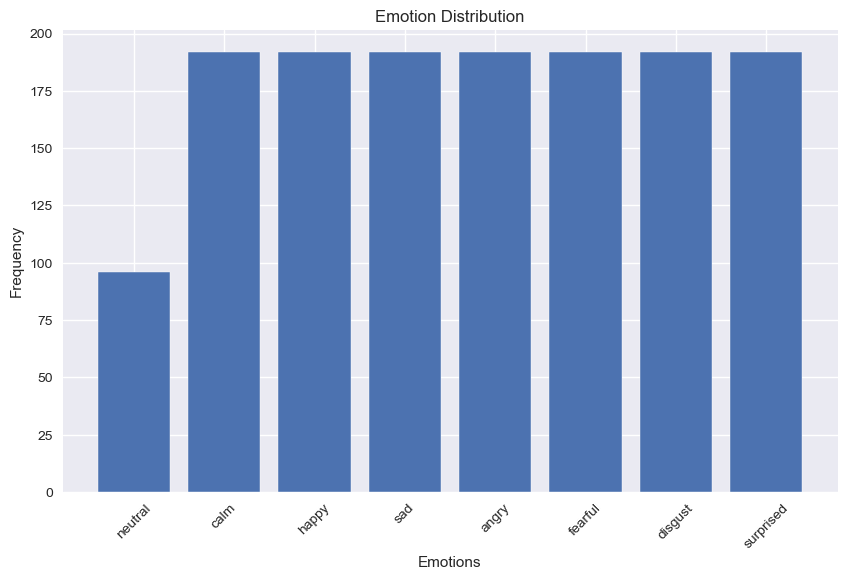

In [5]:
import matplotlib.pyplot as plt

# Count the number of occurrences of each emotion
emotion_counts = {label: speech_labels.count(label) for label in set(speech_labels)}

# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.title('Emotion Distribution')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(ticks=range(len(emotion_labels)), labels=emotion_labels, rotation=45)
plt.show()


Analyzing audio lengths: 100%|████████████| 1440/1440 [00:00<00:00, 2540.96it/s]


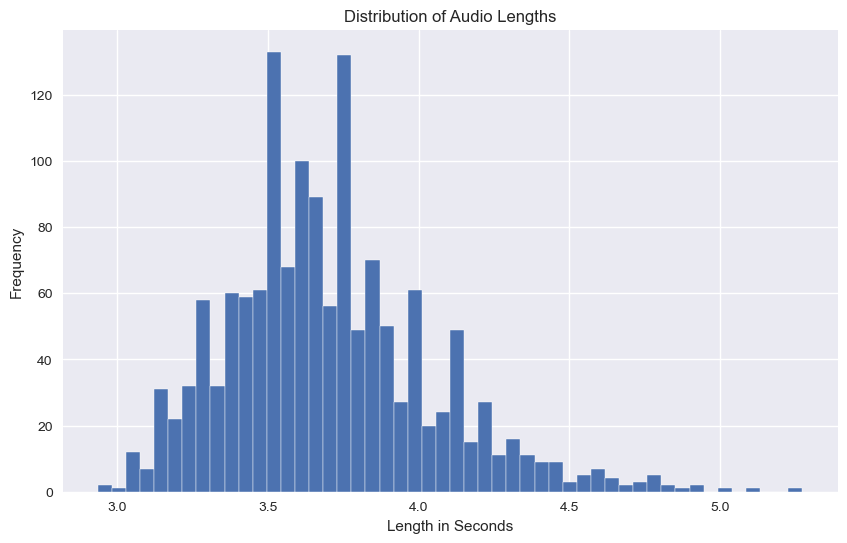

In [6]:
audio_lengths = []

for file_path in tqdm(speech_data, desc="Analyzing audio lengths"):
    y, sr = librosa.load(file_path, sr=None)
    audio_lengths.append(len(y) / sr)  # Length in seconds

# Plot the distribution of audio lengths
plt.figure(figsize=(10, 6))
plt.hist(audio_lengths, bins=50)
plt.title('Distribution of Audio Lengths')
plt.xlabel('Length in Seconds')
plt.ylabel('Frequency')
plt.show()

In [7]:
corrupted_files = []

for file_path in tqdm(speech_data, desc="Checking for corrupted files"):
    try:
        y, sr = librosa.load(file_path, sr=None)
    except Exception as e:
        corrupted_files.append(file_path)

if corrupted_files:
    print(f"Found {len(corrupted_files)} corrupted files.")
else:
    print("No corrupted files found.")

Checking for corrupted files: 100%|███████| 1440/1440 [00:00<00:00, 2789.18it/s]

No corrupted files found.


### Feature Augmentation: 
augmenting feature set with extracted pitch, magnitude, and tempo, as these features can be concatenated with the MFCCs to form a richer feature set.

In [8]:
def extract_additional_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    pitch, mag = librosa.piptrack(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    return np.mean(pitch), np.mean(mag), tempo

# Example for one file
pitch, mag, tempo = extract_additional_features(speech_data[0])
print(f"Pitch: {pitch}, Magnitude: {mag}, Tempo: {tempo}")

def augment_features_with_pitch_tempo(features, speech_data):
    augmented_features = []
    for i, file_path in enumerate(tqdm(speech_data, desc="Augmenting Features")):
        pitch, mag, tempo = extract_additional_features(file_path)
        augmented_feature = np.append(features[i], [pitch, mag, tempo])
        augmented_features.append(augmented_feature)
    return np.array(augmented_features)

augmented_features = augment_features_with_pitch_tempo(features, speech_data)

Pitch: 25.24271583557129, Magnitude: 0.014032362028956413, Tempo: 200.89285714285714


Augmenting Features: 100%|██████████████████| 1440/1440 [02:14<00:00, 10.67it/s]


## prep data

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming `augmented_features` includes MFCCs, pitch, magnitude, and tempo
# And `labels` is your categorical labels array

# Splitting the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(augmented_features, labels, test_size=0.4, random_state=42)

# Further split the temp data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature Scaling
scaler = StandardScaler().fit(X_train)  # Fit on the training data
X_train = scaler.transform(X_train)  # Transform training data
X_val = scaler.transform(X_val)  # Transform validation data
X_test = scaler.transform(X_test)  # Transform test data

# Reshape features for Conv1D input (adding a channel dimension)
# Note: This step is specific to Conv1D; for RNN-based models, you might skip this reshaping.
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (864, 43, 1)
y_train shape: (864, 8)
X_val shape: (288, 43, 1)
y_val shape: (288, 8)
X_test shape: (288, 43, 1)
y_test shape: (288, 8)


### Basic CNN Model (Baseline)

This model will use 1D convolutional layers to extract features from the audio data

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### LSTM Model
This model leverages LSTM layers to process the sequential data.

In [63]:
from tensorflow.keras.layers import LSTM, Bidirectional

def build_lstm_model(input_shape, num_classes):
    '''
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Bidirectional(LSTM(64)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    '''
    model = Sequential([
        Bidirectional(LSTM(units=64, return_sequences=True), input_shape=input_shape),
        Dropout(0.5),
        Bidirectional(LSTM(units=32)),
        Dropout(0.5),
        Dense(units=num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### Hybrid Model (CNN + LSTM)
This model combines CNN layers for feature extraction with LSTM layers for sequence processing.

In [31]:
def build_hybrid_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True),
        LSTM(64),  # Adjusted to ensure the output shape matches the label
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### Simple RNN Model
The Simple RNN model utilizes recurrent neural network layers (SimpleRNN) which are basic but can capture temporal sequences. This model is straightforward and serves well for demonstrating the basics of sequence modeling.

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding

def build_simple_rnn_model(input_shape, num_classes):
    model = Sequential([
        # Embedding layer for text inputs or SimpleRNN for numerical time-series data
        # For numerical time-series, you can start directly with SimpleRNN layer
        SimpleRNN(50, return_sequences=True, input_shape=input_shape),
        SimpleRNN(50),
        Dense(50, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### GRU Model
The GRU (Gated Recurrent Unit) model is an advanced version of the Simple RNN. It solves the vanishing gradient problem through its gating mechanism, making it more effective for capturing long-term dependencies.

In [57]:
from tensorflow.keras.layers import GRU

def build_gru_model(input_shape, num_classes):
    model = Sequential([
        # GRU layer for numerical time-series data
        GRU(50, return_sequences=True, input_shape=input_shape),
        GRU(50),
        Dense(50, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### ConvLSTM Model


In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

def build_ConvLSTM_model(input_shape, num_classes):
    model = Sequential([
        # Assuming input_shape is (time_steps, features), reshape to work with LSTM
        Reshape((input_shape[0], input_shape[1]), input_shape=input_shape),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(units=64, activation='relu'),
        Dropout(0.5),
        Dense(units=num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### Deeper CNN

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2

def build_deep_cnn_1d_model(input_shape, num_classes):
    model = Sequential()
    
    # Conv1D Block 1
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    # Conv1D Block 2
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    # Conv1D Block 3
    model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### Deep CRNN

In [101]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, Bidirectional, Reshape

def build_crnn_model(input_shape, num_classes):
    model = Sequential([
        Reshape((input_shape[0], input_shape[1], 1), input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),  # Added padding='same'
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 1)),  # Adjusted pool size
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),  # Added padding='same'
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 1)),  # Adjusted pool size
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),  # Added padding='same'
        BatchNormalization(),
        GlobalAveragePooling2D(),
        
        Flatten(),
        Reshape((-1, 128)),  # Reshape to add timestep dimension
        Dense(128, activation='relu'),
        Dropout(0.5),
        
        # Bidirectional LSTM for capturing temporal dependencies
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### Define a Training Function
To streamline the process, we'll define a function that trains a model and evaluates its performance:

In [54]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def train_and_evaluate_model(model, model_name, epochs=250, batch_size=8):
    print(f"Training {model_name}...")
    
    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min', restore_best_weights=True),
        ModelCheckpoint(f'{model_name}_best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=0, mode='min')
    ]
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=callbacks
    )

    print(f"Evaluating {model_name}...")
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy*100:.2f}%")

    return history, accuracy


### run the models

In [102]:
# Example definitions (you'll need to adjust these based on your actual dataset)
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

# Adding the new models into the models dictionary
models = {
    #"CNN": build_cnn_model(input_shape, num_classes),
    #"LSTM": build_lstm_model(input_shape, num_classes),
    #"Hybrid CNN+LSTM": build_hybrid_model(input_shape, num_classes),
    #"Simple RNN": build_simple_rnn_model(input_shape, num_classes),
    #"GRU": build_gru_model(input_shape, num_classes),
    #'ConvLSTM':build_ConvLSTM_model(input_shape, num_classes),
    #'Deep CNN':build_deep_cnn_1d_model(input_shape, num_classes),
    'CRNN':build_crnn_model(input_shape, num_classes)
}

model_performances = {}
model_histories = {}  # This will store the history objects for each model

for model_name, model in models.items():
    print(f"Training {model_name}...")
    history, accuracy = train_and_evaluate_model(model, model_name)
    model_performances[model_name] = accuracy
    model_histories[model_name] = history

best_model = max(model_performances, key=model_performances.get)
print(f"Best performing model: {best_model} with accuracy: {model_performances[best_model]*100:.2f}%")


Training CRNN...
Training CRNN...
Epoch 1/250
108/108 [==============================] - 5s 22ms/step - loss: 2.0431 - accuracy: 0.1875 - val_loss: 2.0886 - val_accuracy: 0.1285 - lr: 0.0010
Epoch 2/250
108/108 [==============================] - 2s 16ms/step - loss: 1.9659 - accuracy: 0.2396 - val_loss: 2.1848 - val_accuracy: 0.1285 - lr: 0.0010
Epoch 3/250
108/108 [==============================] - 2s 15ms/step - loss: 1.8858 - accuracy: 0.2697 - val_loss: 2.3411 - val_accuracy: 0.1285 - lr: 0.0010
Epoch 4/250
108/108 [==============================] - 2s 16ms/step - loss: 1.8037 - accuracy: 0.3067 - val_loss: 2.4452 - val_accuracy: 0.1493 - lr: 0.0010
Epoch 5/250
108/108 [==============================] - 2s 16ms/step - loss: 1.6758 - accuracy: 0.3623 - val_loss: 1.8929 - val_accuracy: 0.2569 - lr: 8.0000e-04
Epoch 6/250
108/108 [==============================] - 2s 16ms/step - loss: 1.5866 - accuracy: 0.3981 - val_loss: 1.6189 - val_accuracy: 0.3681 - lr: 8.0000e-04
Epoch 7/250
108/

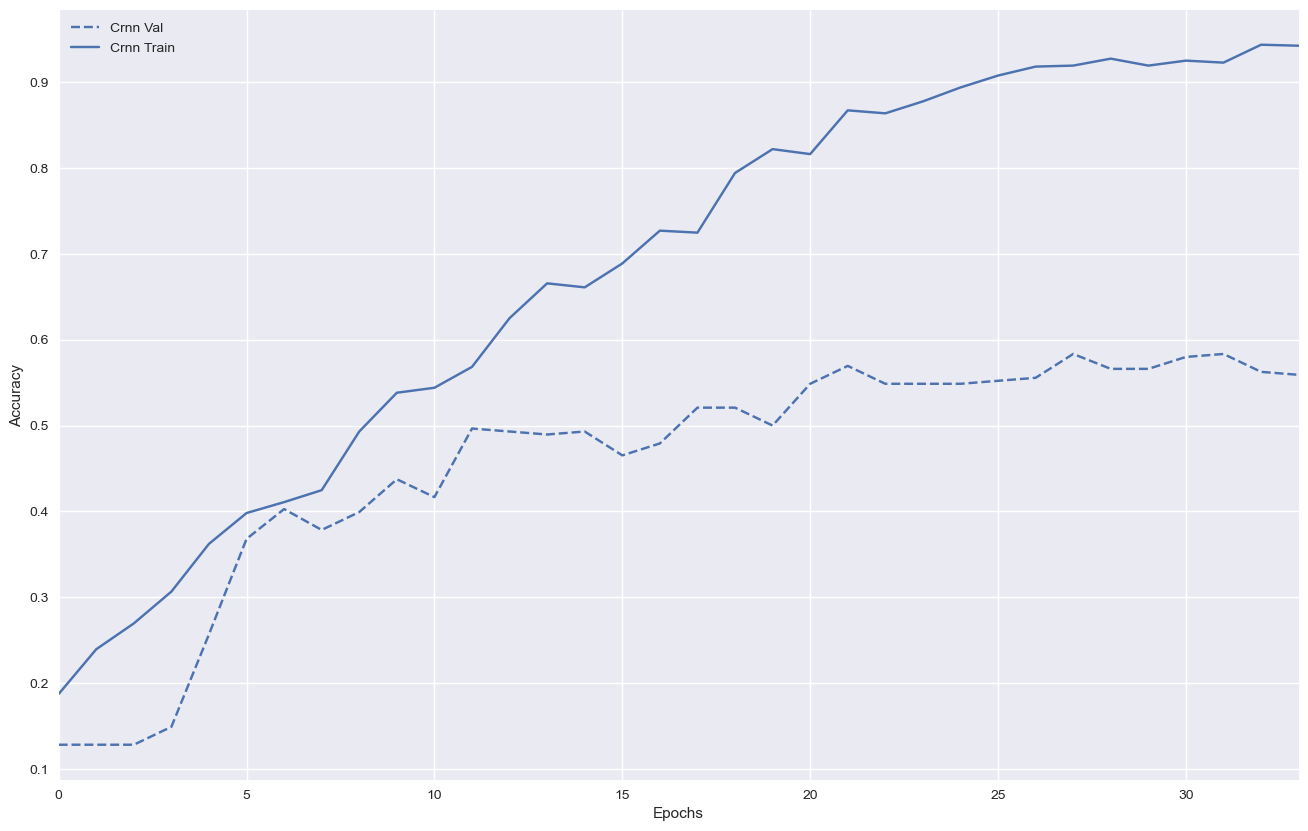

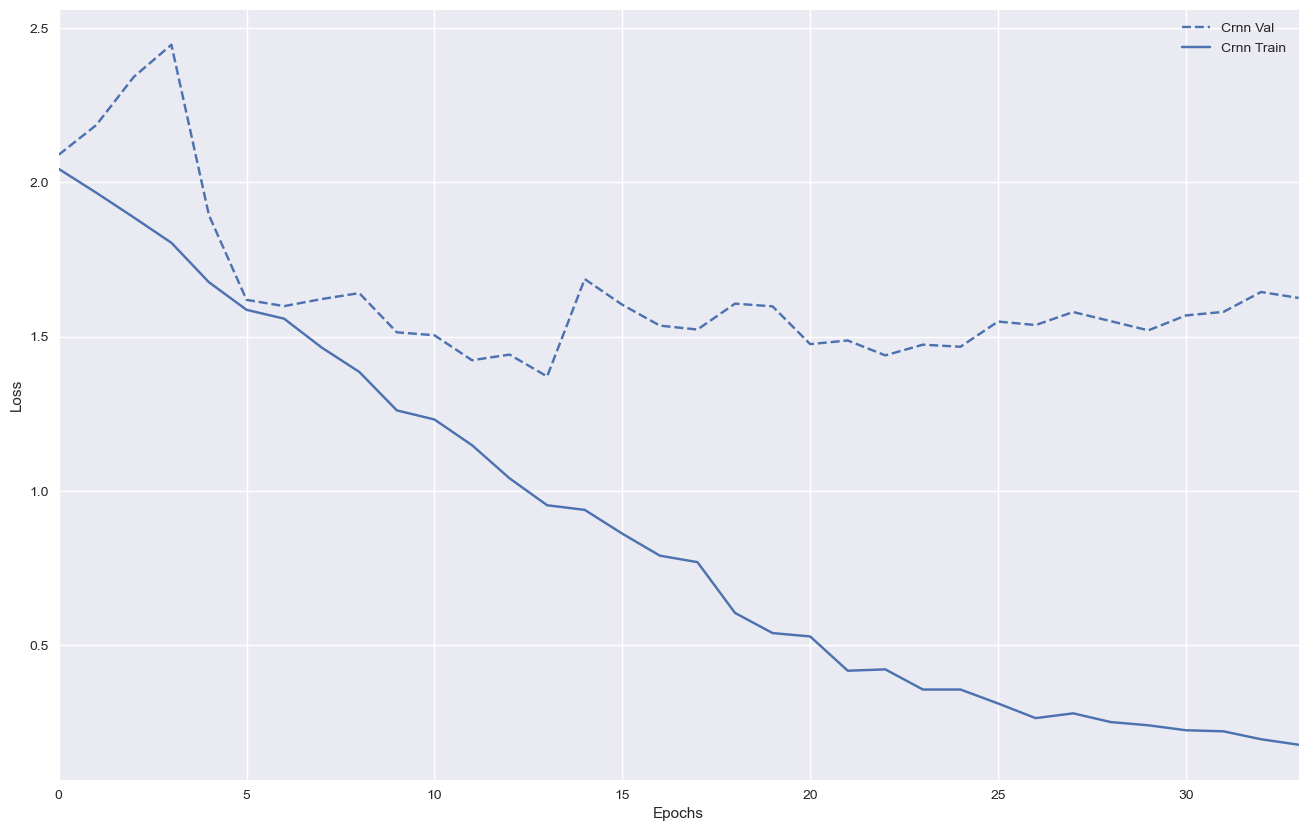

In [103]:
# Function to plot history
def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(16,10))
    max_epochs = 0  # Initialize to track the maximum number of epochs

    for name, history in histories.items():
        epochs = len(history.epoch)
        max_epochs = max(max_epochs, epochs)  # Update max_epochs if current history has more epochs
        val = plt.plot(history.epoch, history.history['val_'+key], '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(), label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()
    plt.xlim([0, max_epochs - 1])  # Adjust the x-axis limit
    plt.show()


# Assuming model_histories stores the training history for each model
plot_history(model_histories, key='accuracy')
plot_history(model_histories, key='loss')


### attention transformer

In [111]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

class PositionalEncoding(Layer):
    def __init__(self, max_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(max_len, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                      np.arange(d_model)[np.newaxis, :],
                                      d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

def create_transformer_model(input_shape, num_classes, num_layers=4, d_model=128, num_heads=8, dff=512, dropout_rate=0.1):
    inputs = Input(shape=input_shape)

    # Positional encoding
    pos_enc = PositionalEncoding(input_shape[0], d_model=d_model)(inputs)

    # Transformer Encoder
    x = pos_enc
    for _ in range(num_layers):
        # Multi-Head Attention
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        attn_output = LayerNormalization(epsilon=1e-6)(attn_output + x)

        # Feed Forward Network
        ffn_output = Dense(dff, activation='relu')(attn_output)
        ffn_output = Dense(d_model)(ffn_output)  # Adjusting the dimension to match the input dimension
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(ffn_output + attn_output)

    # Output layer
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model
    
# Compile the model
transformer_model = create_transformer_model(input_shape=X_train[0].shape, num_classes=y_train.shape[1])
transformer_model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])

epochs = 10  # Define the number of epochs for training
batch_size = 8


# Train the model
transformer_history = transformer_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

# Evaluate the model
transformer_loss, transformer_accuracy = transformer_model.evaluate(X_test, y_test, verbose=0)
print(f"Transformer Model Test Accuracy: {transformer_accuracy*100:.2f}%")


Epoch 1/10


ValueError: in user code:

    File "/Users/avielstein/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/Users/avielstein/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/avielstein/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/Users/avielstein/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/avielstein/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "/Users/avielstein/anaconda3/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/avielstein/anaconda3/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/avielstein/anaconda3/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/avielstein/anaconda3/lib/python3.11/site-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "/Users/avielstein/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 5777, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(64,) and logits.shape=(8, 8)
